In [2]:
import os
import time
import random
import math
import requests
import json
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
from scipy.io import wavfile
import soundfile as sf
import librosa
from python_speech_features import mfcc
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
import gc
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from shutil import copyfile

In [12]:
max_sec = 6

def get_signal(path, augment=None):
    sig, sr = librosa.load(path, 16000)
    
    if augment!=None:
        try:
            if augment[0] == 'v': # vocal tract length pertubation
                sig = vtlp_aug.augment(sig)
            elif augment[0] == 'p': # [deprecated] pitch shift
                sig = librosa.effects.pitch_shift(sig, sr, n_steps=random.uniform(-1.0, 1.0))
            elif augment[0] == 's': # [deprecated] time stretch
                sig = librosa.effects.time_stretch(sig, rate=random.uniform(0.8, 1.2))
        except:
            sig = []
    if len(sig)/sr > max_sec:
        sig = sig[-max_sec*sr:]
    else:
        sig = np.pad(sig, (0, max_sec*sr-len(sig)), "constant", constant_values=0)
    
    return sig, sr

def get_mfcc(path, augment=None):
    sig, rate = get_signal(path, augment=augment)
    if (len(sig)==0):
        return np.array([[0]*13])
    else:
        return mfcc(sig, rate, winlen=0.03, winstep=0.015, numcep=13)

def delta(a):
    if len(a) > 4:
        result = []
        for i in range(2, len(a) - 2):
            value = (a[i+1] - a[i-1] + 2*(a[i+2] - a[i-2])) * 0.1
            result.append(value)
        return np.pad(result, 2, 'constant', constant_values=0)
    else:
        return np.zeros(len(a))

def get_features(filedir, max_len, augment=None):
    mfcc0 = cmvn(get_mfcc(filedir, augment=augment), True)
    #mfcc1 = np.apply_along_axis(delta, 0, mfcc0)
    #mfcc2 = np.apply_along_axis(delta, 0, mfcc1)

    mfcc_feat = mfcc0 #np.concatenate((mfcc0, mfcc1, mfcc2), axis=1)
    num_frames, frame_size = mfcc_feat.shape[0] , mfcc_feat.shape[1]

    max_features = frame_size * max_len
    features = torch.from_numpy(mfcc_feat.reshape(-1))
    # features = nn.ConstantPad1d((0, max_features - len(features)), 0)(features)
    features = nn.ConstantPad1d((max_features - len(features), 0), 0)(features) # new
    features = features.reshape(max_len,frame_size)
    features = features.view(int(max_len / 2),features.size(1) * 2)
    features = torch.split(features, frame_size, dim=1) # it returns a tuple
    features = (features[0] + features[1]) / 2.0
    return features.float()

def cmvn(vec, variance_normalization=False):
    """ This function is aimed to perform global cepstral mean and
        variance normalization (CMVN) on input feature vector "vec".
        The code assumes that there is one observation per row.
    Args:
        vec (array): input feature matrix
            (size:(num_observation,num_features))
        variance_normalization (bool): If the variance
            normilization should be performed or not.
    Return:
          array: The mean(or mean+variance) normalized feature vector.
    """
    eps = 2**-30
    rows, cols = vec.shape

    # Mean calculation
    norm = np.mean(vec, axis=0)
    norm_vec = np.tile(norm, (rows, 1))

    # Mean subtraction
    mean_subtracted = vec - norm_vec

    # Variance normalization
    if variance_normalization:
        stdev = np.std(mean_subtracted, axis=0)
        stdev_vec = np.tile(stdev, (rows, 1))
        output = mean_subtracted / (stdev_vec + eps)
    else:
        output = mean_subtracted

    return output

## Define model

In [14]:
class VoiceClassifier(nn.Module):
    
    def __init__(self, audio_dim = 13, max_len = 300, 
                 num_kernels = [200,100,50,25],
                 kernel_sizes = [(7,13),(5,100),(3,50),(2,25)]):
        
        super(VoiceClassifier,self).__init__()
        self.convs = nn.ModuleList([])
        self.norms = nn.ModuleList([])
        
        for i in range(0,len(kernel_sizes)):
            self.convs.append(nn.Conv2d(in_channels = 1,
                                        out_channels = num_kernels[i],
                                        kernel_size = kernel_sizes[i],
                                        stride = 2))
            self.norms.append(nn.BatchNorm2d(num_kernels[i]))
        
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(204, 2)  # Determine in runtime
        self.softmax = nn.Softmax(dim=1)

        gc.collect()
        
    def forward(self, x):
        # x = [N, max_len, 512]
        
        for conv, norm in zip(self.convs, self.norms):
            x = x.unsqueeze(1) # x = [N, num_channels, max_len, 512]
            x = F.relu(norm(conv(x))) # x = [N, num_kernel, K, 1]
            x = x.squeeze(3) # x = [N, num_kernel, K]
            x = x.permute(0, 2, 1) # x = [N, K, num_kernel]
            x = F.max_pool1d(x, 2) # x = [N, K, num_kernel / 2] # x = F.avg_pool1d(x, 2)
            x = self.dropout(x)
        
        x = x.reshape(-1, x.size(1) * x.size(2))
        logit = self.fc1(x)
        logit = self.softmax(logit)

        gc.collect()
        
        return logit

In [3]:
class MelspecClassifier(nn.Module):
    
    def __init__(self, audio_dim = 30, max_len = 300, 
                 num_channels = [1, 64, 64, 64],
                 num_kernels = [64, 64, 64, 32],
                 kernel_sizes = [(3,3),(3,3),(3,3),(3,3)]):
        
        super(MelspecClassifier,self).__init__()
        self.convs = nn.ModuleList([])
        self.norms = nn.ModuleList([])
        
        for i in range(0,len(kernel_sizes)):
            self.convs.append(nn.Conv2d(in_channels = num_channels[i],
                                        out_channels = num_kernels[i],
                                        kernel_size = kernel_sizes[i],
                                        padding=(1,1),
                                        stride = 1))
            self.norms.append(nn.BatchNorm2d(num_kernels[i]))
        
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(384, 2)  # Determine in runtime
        self.softmax = nn.Softmax(dim=1)

        gc.collect()
        
    def forward(self, x):
        # x = [N, max_len, 512]
        x = x.unsqueeze(1)
        
        # convolution -> batch-norm -> relu -> max-pool
        for i in range(len(self.convs)): # conv, norm in zip(self.convs, self.norms):
            #x = F.relu(norm(conv(x))) # x = [N, num_kernel, K, 1]
            x = self.convs[i](x)
            x = self.norms[i](x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2, stride=2) if i<2 else F.max_pool2d(x, 4, stride=4) # x = [N, K, num_kernel / 2] # x = F.avg_pool1d(x, 2)
            #print(i, x.shape)
            x = self.dropout(x)
        
        # flatten
        x = x.reshape(-1, x.size(1) * x.size(2) * x.size(3))
        
        logit = self.fc1(x)
        logit = self.softmax(logit)

        gc.collect()
        
        return logit

In [16]:
wav2senti = VoiceClassifier()
print(sum(p.numel() for p in wav2senti.parameters() if p.requires_grad))

features0 = get_features('./repository/vnlp.engine.voicesenti/temp/audio.wav', 600).unsqueeze(0)
logits = wav2senti(features0).squeeze(0)
pprint(logits)

78485
tensor([0.8046, 0.1954], grad_fn=<SqueezeBackward1>)


## Model training watch

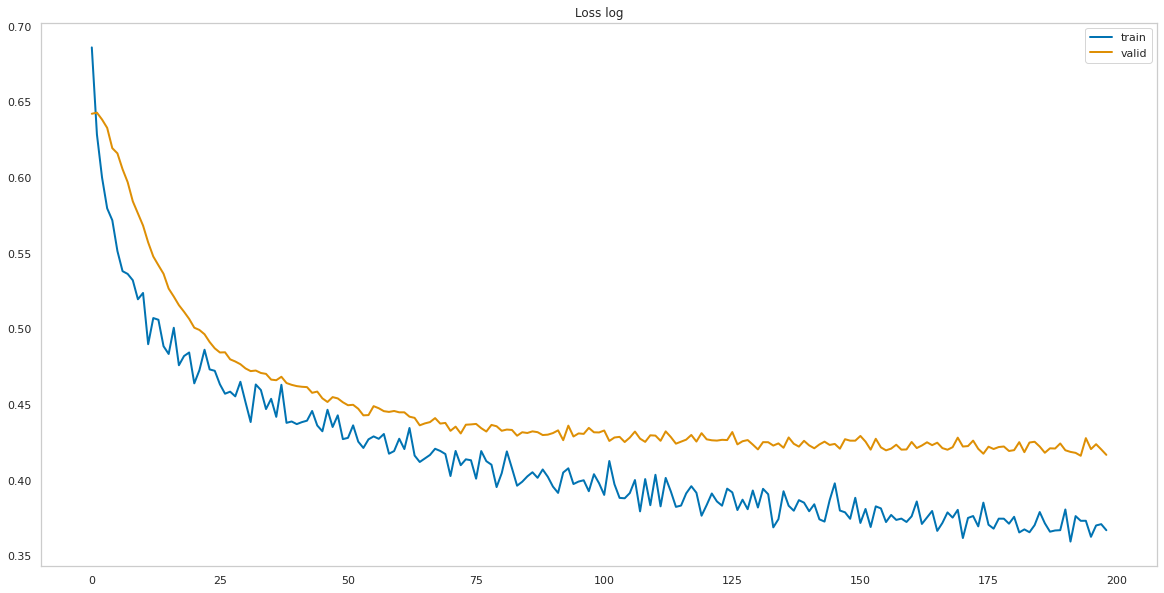

In [33]:
with open('train_loss_log.txt', 'r') as f:
    train_loss_log = [float(line.strip()) for line in f.readlines()]
with open('valid_loss_log.txt', 'r') as f:
    valid_loss_log = [float(line.strip()) for line in f.readlines()]
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("colorblind")
figure(num=None, figsize=(20, 10))
#plt.ylim(0.6,0.8)
plt.title("Loss log")
plt.plot(train_loss_log, linewidth=2, label='train')
plt.plot(valid_loss_log, linewidth=2, label='valid')
plt.legend()

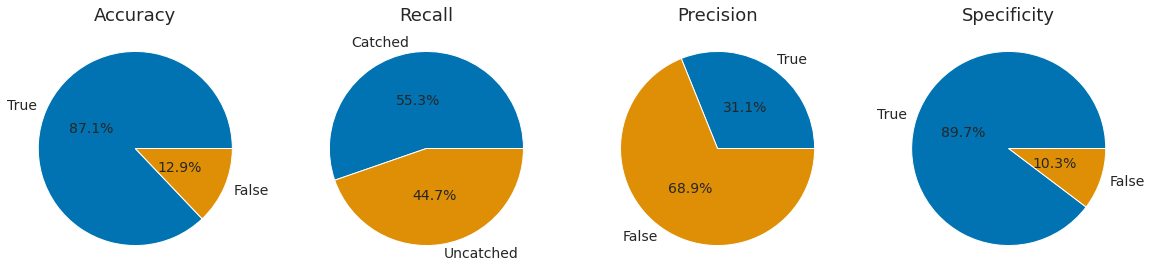

In [59]:
figure(num=None, figsize=(20, 10))
plt.subplot(141)
plt.pie(x=[0.871, 0.129], autopct="%.1f%%", labels=['True', 'False'], pctdistance=0.5, textprops={'fontsize': 14})
plt.title("Accuracy", fontsize=18)
plt.subplot(142)
plt.pie(x=[0.553, 0.447], autopct="%.1f%%", labels=['Catched', 'Uncatched'], pctdistance=0.5, textprops={'fontsize': 14})
plt.title("Recall", fontsize=18)
plt.subplot(143)
plt.pie(x=[0.311, 0.689], autopct="%.1f%%", labels=['True', 'False'], pctdistance=0.5, textprops={'fontsize': 14})
plt.title("Precision", fontsize=18)
plt.subplot(144)
plt.pie(x=[0.897, 0.103], autopct="%.1f%%", labels=['True', 'False'], pctdistance=0.5, textprops={'fontsize': 14})
plt.title("Specificity", fontsize=18)
#plt.show()
plt.savefig('visualization/metrics.png')

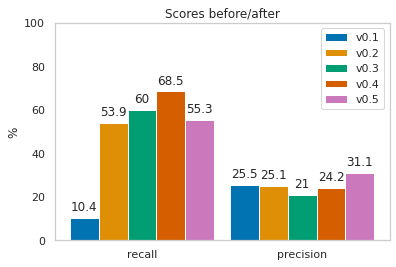

In [44]:
labels = ['recall', 'precision']
v01 = [10.4, 25.5]
v02 = [53.9, 25.1]
v03 = [60.0, 21.0]
v04 = [68.5, 24.2]
v05 = [55.3, 31.1]

x = np.arange(len(labels))  # the label locations
width = 0.18  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*2, v01, width, label='v0.1')
rects2 = ax.bar(x - width*1, v02, width, label='v0.2')
rects3 = ax.bar(x + width*0, v03, width, label='v0.3')
rects4 = ax.bar(x + width*1, v04, width, label='v0.4')
rects5 = ax.bar(x + width*2, v05, width, label='v0.5')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%')
ax.set_title('Scores before/after')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,4), rotation=0, 
                textcoords="offset points", ha="center", va="bottom")

ax.set_ylim(0, 100)

plt.savefig('visualization/before_after.png')

## Ways to improve model
- [x] Adjust multifold
- [x] Adjust lr
- [x] Change MFCC delta calculation
- [x] Adjust MFCC winlen/winstep
- [x] Retry with numcep=13, remove delta-delta features
- [x] Retry with numcep=26, remove delta & delta-delta features
- [x] Retry with soundfile instead of scipy
- [x] Convert to 16k
- [ ] Data augmentation
- [x] Increase batch size & lr
- [x] Modify loss function

## Model validation


### Tablular classification

In [360]:
train_df = pd.read_csv('training_dataset/tabular_predue_crossed_label_train.csv').fillna(0)
test_df = pd.read_csv('training_dataset/tabular_predue_crossed_label_test.csv').fillna(0)

train_df.head()

filename  train_test  label  \
0  G7EAR951957QJ5H4G1AHQ458OK07EGKJ_2021-01-11_01...           0      0   
1  G7EAR951957QJ5H4G1AHQ458OK07EGKJ_2021-01-11_01...           0      0   
2  G7EAR951957QJ5H4G1AHQ458OK07EGKJ_2021-01-11_01...           0      0   
3  G7EAR951957QJ5H4G1AHQ458OK07EGKJ_2021-01-11_01...           0      0   
4  G7EAR951957QJ5H4G1AHQ458OK07EGKJ_2021-01-11_01...           0      0   

   sig_mean   sig_std  rmse_mean  rmse_std   silence  harmonic  auto_corr_max  \
0  0.113515  0.202570   0.152340  0.130750  0.380952  0.926861      30.908667   
1  0.138435  0.203159   0.188914  0.072082  0.094340  0.003471      27.081235   
2  0.102858  0.184418   0.138111  0.121313  0.384615  0.062470      25.770703   
3  0.111728  0.164448   0.148470  0.067503  0.163934 -0.000445      17.790507   
4  0.117069  0.195423   0.160491  0.107717  0.304348  0.083054      27.625296   

   auto_corr_std  
0      16.011458  
1      15.747490  
2      18.118172  
3       9.755240  
4      10.315329

In [361]:
y_train = train_df['label']
y_test = test_df['label']

x_train = train_df.drop(['filename', 'train_test', 'label'], axis=1)
x_test = test_df.drop(['filename', 'train_test', 'label'], axis=1)

class_weight = dict(pd.Series(y_train).value_counts(normalize=True))

x_test

sig_mean   sig_std  rmse_mean  rmse_std   silence  harmonic  \
0     0.077819  0.138552   0.103446  0.090530  0.400000  0.000167   
1     0.095825  0.154998   0.134537  0.076755  0.181159 -0.000399   
2     0.114929  0.195418   0.154998  0.114693  0.269231  0.443081   
3     0.124695  0.207197   0.185331  0.092306  0.111628 -0.000567   
4     0.148123  0.239210   0.199343  0.131379  0.250000  0.145317   
...        ...       ...        ...       ...       ...       ...   
3154  0.028011  0.065270   0.045860  0.045836  0.473684  0.031832   
3155  0.135224  0.181052   0.172461  0.051169  0.000000  0.010286   
3156  0.156325  0.224557   0.211198  0.074850  0.083333  0.031093   
3157  0.028599  0.057299   0.039494  0.040802  0.457143 -0.048230   
3158  0.041990  0.071028   0.062644  0.033183  0.187500  0.000348   

      auto_corr_max  auto_corr_std  
0         14.417965       6.500919  
1         17.114969      15.676326  
2         28.090423      13.799909  
3         31.105932      33.911410  
4         40.235368      14.162362  
...             ...            ...  
3154       3.625954       1.627152  
3155      19.525983      10.220423  
3156      32.455427      15.191954  
3157       2.633459       1.285701  
3158       3.730148       1.718677  

[3159 rows x 8 columns]

In [237]:
print(sum(y_train), sum(y_train)/len(y_train)*100)
print(sum(y_test), sum(y_test)/len(y_test)*100)

983 6.919124375307947
214 6.774295663184553


In [9]:
rf_classifier = RandomForestClassifier(n_estimators=1200, max_features=5, max_depth=3, min_samples_split=25, class_weight=class_weight)
rf_classifier.fit(x_train, y_train)
print('Train finished!')

Train finished!


In [359]:
x_train

sig_mean   sig_std  rmse_mean  rmse_std   silence  harmonic  \
0      0.113515  0.202570   0.152340  0.130750  0.380952  0.926861   
1      0.138435  0.203159   0.188914  0.072082  0.094340  0.003471   
2      0.102858  0.184418   0.138111  0.121313  0.384615  0.062470   
3      0.111728  0.164448   0.148470  0.067503  0.163934 -0.000445   
4      0.117069  0.195423   0.160491  0.107717  0.304348  0.083054   
...         ...       ...        ...       ...       ...       ...   
14202  0.196008  0.293833   0.252682  0.138458  0.230769  0.600283   
14203  0.096935  0.159886   0.121464  0.102159  0.393939  0.000106   
14204  0.127437  0.225889   0.174343  0.140201  0.305556  0.023275   
14205  0.157079  0.237589   0.220723  0.084488  0.035294  0.001069   
14206  0.178587  0.229863   0.220949  0.061670  0.075342 -0.003777   

       auto_corr_max  auto_corr_std  
0          30.908667      16.011458  
1          27.081235      15.747490  
2          25.770703      18.118172  
3          17.790507       9.755240  
4          27.625296      10.315329  
...              ...            ...  
14202      57.028623      16.044191  
14203      18.348894      11.496669  
14204      38.256853      18.692922  
14205      38.147823      28.399334  
14206      29.724698      24.039926  

[14207 rows x 8 columns]

In [238]:
xgb_classifier = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=2,
                                   booster='gbtree', n_jobs=16, class_weight=class_weight)
xgb_classifier.fit(x_train, y_train)

/home/kiethoang/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:34] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight", "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:43:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight={0: 0.9308087562469205, 1: 0.06919124375307947},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1200, n_jobs=16,
              num_class=2, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              sub_sample=0.8, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

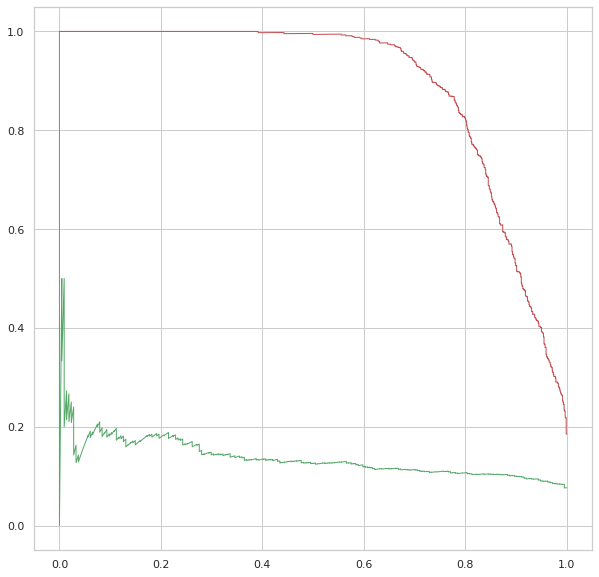

In [241]:
y_overfit = xgb_classifier.predict_proba(x_train)[:,1]
y_prob_harmony = xgb_classifier.predict_proba(x_test)[:,1]

figure(num=None, figsize=(10, 10))

prec, recl, thresholds = precision_recall_curve(y_train, y_overfit)
plt.plot(recl, prec, 'r-', linewidth=1, label='Random Forest Train')

prec, recl, thresholds = precision_recall_curve(y_test, y_prob_harmony)
plt.plot(recl, prec, 'g-', linewidth=1, label='Random Forest Test')

plt.grid()

In [57]:
harmonic_prob = pd.DataFrame()
harmonic_prob['wav_file'] = test_df['wav_file']
harmonic_prob['prediction'] = y_prob_
harmonic_prob.head()

wav_file  prediction
0   FE_genesys_78h/audio/c098495e524246d19ae83f17a...    0.003455
6   FE_genesys_78h/audio/fef0cba43de240249ecd0d206...    0.002650
9   FE_genesys_78h/audio/0562d3a6c29a477f987561abc...    0.000035
13  FE_genesys_78h/audio/e519078cfd174195a003fe968...    0.000083
21  FE_genesys_78h/audio/98eaacca448b491e843b2db9a...    0.001314

### Voice sentiment inference

In [20]:
def redirect_path(p):
    p_split = p.split('/')
    p_split[2] = p_split[2].replace('wav', 'mfcc')
    if '78h' in p_split[0]: p_split[2] = p_split[2].split('__')[1]
    p_split[1] = p_split[0]
    p_split[0] = 'training_dataset'
    p = '/'.join(p_split)
    return p

In [26]:
df = pd.read_csv('training_dataset/tabular_test_dataset_telesale+.csv')
paths = df.wav_file.apply(redirect_path).to_list()
trans = df.transcript.to_list()
y_test = df.label.to_list()
print(len(paths), len(trans), len(y_test))
print(sum(y_test))

X_test = []
for path in tqdm(paths):
    features = torch.load(path)
    X_test.append(features)
print(len(X_test), X_test[0].shape)

  1%|▍                                            | 184/19261 [00:00<00:10, 1836.80it/s]

19261 19261 19261
94


100%|███████████████████████████████████████████| 19261/19261 [00:04<00:00, 4326.07it/s]

19261 torch.Size([300, 13])


In [60]:
id_sorter = df[0].to_list()
print(id_sorter[:3])

harmonic_prob.wav_file = harmonic_prob.wav_file.astype("category")
harmonic_prob.wav_file.cat.set_categories(id_sorter, inplace=True)
harmonic_prob.sort_values(['wav_file'], inplace=True)

y_prob_harmony = harmonic_prob.prediction.to_list()

['FE_genesys_78h/audio/44d5900b4d0d40c6a0df35e1202a9150__4BV3CEU4SH71P0NN5TFDBD1P9C05P947_2021-01-11_03-08-20-012401FF-1258AF15-00000001-client_53.wav', 'FE_genesys_78h/audio/299655749a3a4e69a94419c49d7e50d1__4BV3CEU4SH71P0NN5TFDBD1P9C05R37F_2021-01-11_04-07-52-012301FF-1258FC06-00000001-agent_127.wav', 'FE_genesys_78h/audio/59ab648e53854f22846a1bcb41a22cb7__4BV3CEU4SH71P0NN5TFDBD1P9C05RDJJ_2021-01-11_04-18-49-012001FF-1258FF36-00000001-client_25.wav']


/home/kiethoang/.local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [27]:
wav2senti = VoiceClassifier()
wav2senti.load_state_dict(torch.load('checkpoints/checkpoint_best_loss.pt', map_location=torch.device('cuda')))#['model_state_dict'])
wav2senti.eval()
wav2senti.to('cuda')

y_mfcc = []

for i in tqdm(range(0, len(y_test), 1000)):
    X_test_ = torch.stack(X_test[i : i + 1000]).cuda()
    y_mfcc.extend(wav2senti(X_test_).data[:, 1].cpu().numpy())

100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.61it/s]


In [28]:
y_mfcc = np.array(y_mfcc)
np.save('y_mfcc.npy', y_mfcc)

In [95]:
alpha = 1/5
y_general = [alpha*y1 + (1-alpha)*y2 for y1, y2 in zip(y_mfcc, y_tfidf)]

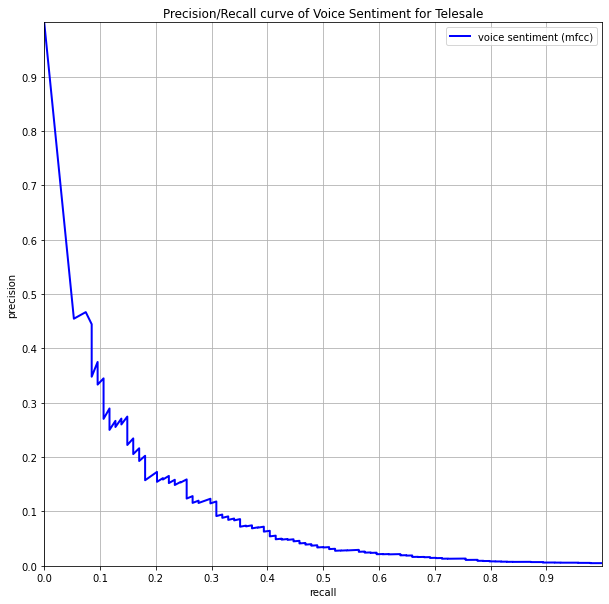

In [32]:
figure(num=None, figsize=(10, 10))

# y_gen = [(y1+y2)/2 for y1, y2 in zip(y_text, y_voice)]
# prec, recl, thresholds = precision_recall_curve(yt, yt_voice)
# plt.plot(recl, prec, 'r-', linewidth=1, label='telesale mfcc_plus train')

# prec, recl, thresholds = precision_recall_curve(y78, y_voice78)
# plt.plot(recl, prec, 'g-', linewidth=2, label='checkpoint_best_loss')

prec, recl, thresholds = precision_recall_curve(y_test, y_mfcc)
plt.plot(recl, prec, 'b-', linewidth=2, label='voice sentiment (mfcc)')

# prec, recl, thresholds = precision_recall_curve(y_test, y_voice_)
# plt.plot(recl, prec, 'g-', linewidth=2, label='voice sentiment (mfcc)')

# prec, recl, thresholds = precision_recall_curve(y_test, y_prob_harmony)
# plt.plot(recl, prec, 'g-', linewidth=2, label='voice sentiment (harmony)')

# prec, recl, thresholds = precision_recall_curve(y_test, y_tfidf)
# plt.plot(recl, prec, 'g-', linewidth=2, label='text sentiment')

# prec, recl, thresholds = precision_recall_curve(y_test, y_general)
# plt.plot(recl, prec, 'k-', linewidth=2, label='general sentiment')

#plt.scatter([0.224], [0.696], color='r')

plt.title('Precision/Recall curve of Voice Sentiment for Telesale')
plt.xlabel('recall')
plt.xticks(np.arange(0, 1, step=0.1))
plt.xlim(0, 1)
plt.ylabel('precision')
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylim(0, 1)
plt.legend(loc=1)
plt.grid()

plt.savefig('visualization/P_R_curve.png')

In [23]:
for p, r, thres in zip(prec, recl, thresholds):
    if 0.4<r and 0.017<p:
        f1 = 2*p*r / (p+r)
        print(f'{thres:.7}\t{r:.4}\t{p:.4}\t{f1:.4}')

0.5104355	0.4043	0.017	0.03263
0.5107992	0.4043	0.01701	0.03265
0.510852	0.4043	0.01702	0.03266
0.5108629	0.4043	0.01703	0.03267
0.510981	0.4043	0.01703	0.03269
0.5110211	0.4043	0.01704	0.0327
0.5111758	0.4043	0.01705	0.03272
0.5113308	0.4043	0.01706	0.03273


In [49]:
y_binary = [1 if yy>0.475 else 0 for yy in y_text]
for i in range(len(y_test)):
    if (y_test[i]==0 and y_binary[i]==1):
        print(f'{y_text[i]:0.3}\t {transcripts[i]}')

0.527	 rồi nghe chị
0.535	 hả
0.541	 trễ bữa hai bữa làm gì thấy ghê vậy
0.532	 chào chị em duyên gọi từ công ty tài chính ép e á chị cái hợp đồng vay tiền mua hàng điện máy của mình trễ hạn một ngày rồi một triệu không trăm hai mươi tám ngàn đồng ra thế giới di động điện máy xanh ngân hàng thanh toán liền đi chị
0.61	 mốt mốt mốt
0.596	 dạ sao
0.501	 các anh làm ăn tầm bậy tầm bạ cũng vừa vừa
0.486	 anh ơi
0.493	 chị đóng thiếu sáu mươi sáu ngàn rồi trong chiều nay cầm hồ sơ giấy tờ ra
0.48	 cứ
0.517	 tôi không
0.487	 tôi không tiếc cái năm mươi nghìn nhưng mà ý tôi bảo làm sao mà lại gửi gửi cái kiểu như thế này
0.582	 lê thị hồng đúng không ạ
0.476	 vậy cảm ơn anh chúc ngày tốt lành xin chào anh ạ
0.482	 chuyển khi nào ạ
0.553	 bao giờ có tiền thì trả
0.488	 ráng mười hai tui đi đóng
0.543	 dạ a lô em như gọi từ công ty tài chính ép e á
0.483	 hai mấy mới tiền mà đóng từ ngày mười hai bây giờ lại bảo ngày mười một


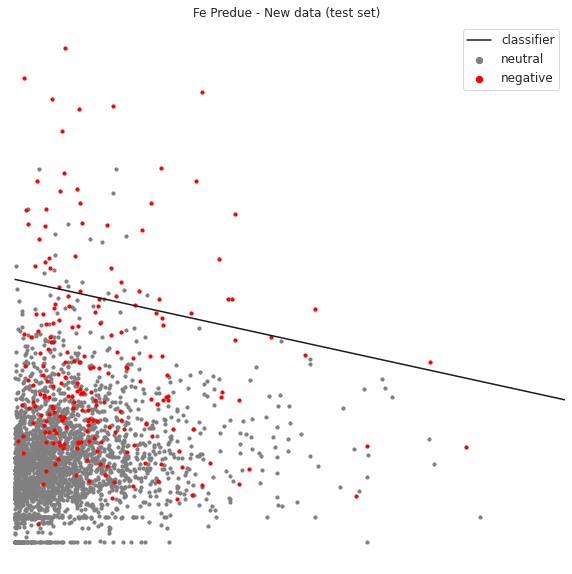

In [356]:
y_pairs = np.array([y_prob_harmony, y_prob_text]).T
figure(num=None, figsize=(10, 10))
colors = {0:'gray', 1:'red'}
labels = {0:'neutral', 1:'negative'}
for i in range(2):
    grouped_points = y_pairs[np.where(np.array(y_test)==i)]
    plt.scatter(grouped_points[:,0], grouped_points[:,1], c=colors[i], s=10, label=labels[i])
    #plt.scatter(y_voice78[idx], y_prob_text[idx], s=3)

x = np.linspace(0,1,100)
y = -1*x/6 + 0.38*6/5
plt.plot(x, y, '-k', label='classifier')

plt.title('Fe Predue - New data (test set)')
plt.xlim(-0.01, 0.7)
# plt.ylim(0, 1)
plt.axis('off')
plt.xlabel('voice sentiment')
plt.ylabel('text sentiment')
plt.legend(fontsize=12, markerscale=2, loc=1)
plt.savefig('separater-line.png')

### Text sentiment inference

In [ ]:
def text_sentiment_inference(trans, with_probe=False, api='http://192.168.1.70:8000/api/v1.3/text_sentiment/genesys'):
    if with_probe:
        api += "?probability=true"
    
    trans = {"data": trans}
    trans = json.dumps(trans).encode('utf-8')

    api_callback = requests.post(api, data=trans)
    df_api_callback = pd.read_json(api_callback.text, encoding='utf-8')
    
    text_sentiment_results = df_api_callback['sentiment'].to_list()
    
    if with_probe:
        probabilities = df_api_callback['probability'].to_list()
        text_sentiment_results = [pr/100 if se == 'Negative' else 1-pr/100 for se, pr in zip(text_sentiment_results, probabilities)]
    else:
        text_sentiment_results = [1 if se == 'Negative' else 0 for se in text_sentiment_results]

    return text_sentiment_results

y_text = []
for i in tqdm(range(0, len(t), 1000)):
    tt = t[i : i + 1000].to_list()
    y_text.extend(text_sentiment_inference(tt, with_probe=False))

#### Text model

In [13]:
df_text = pd.read_csv('/home/kiethoang/Projects/VoiceSentiment/training_dataset/train_predue_crossed_label.csv', sep='\t').fillna('dạ')
transcripts = df_text.utterance.to_list()
labels = df_text.label.to_list()
len(transcripts), len(labels)

(14207, 14207)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2))
features = tfidf.fit_transform(transcripts).toarray()
print(features.shape)

(14207, 5658)


In [15]:
df_text_test = pd.read_csv('/home/kiethoang/Projects/VoiceSentiment/training_dataset/test_predue_crossed_label.csv', sep='\t').fillna('dạ')
transcripts_test = df_text_test.utterance.to_list()
labels_test = df_text_test.label.to_list()
features_test = tfidf.transform(transcripts_test).toarray()
features_test.shape

(3159, 5658)

In [16]:
class_weight = dict(df_text.label.value_counts(normalize=True))
class_weight

{0: 0.9308087562469205, 1: 0.06919124375307947}

In [10]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()
mnb_classifier.fit(features, labels)

MultinomialNB()

In [236]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=50)
lr_classifier.fit(features, labels)

/home/kiethoang/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=50, multi_class='multinomial')

In [17]:
from sklearn.svm import LinearSVC

svc_classifier = LinearSVC(C=0.2) #class_weight={0: 0.9, 1: 0.1})
svc_classifier.fit(features, labels)

LinearSVC(C=0.2)

In [49]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(features, labels)

RandomForestClassifier(min_samples_split=25, n_estimators=600)

In [34]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.05,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=100, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)
mlp_classifier.fit(features, labels)

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(600,),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=100,
              momentum=0.8, warm_start=True)

In [18]:
y_pred_probs = svc_classifier._predict_proba_lr(features_test)

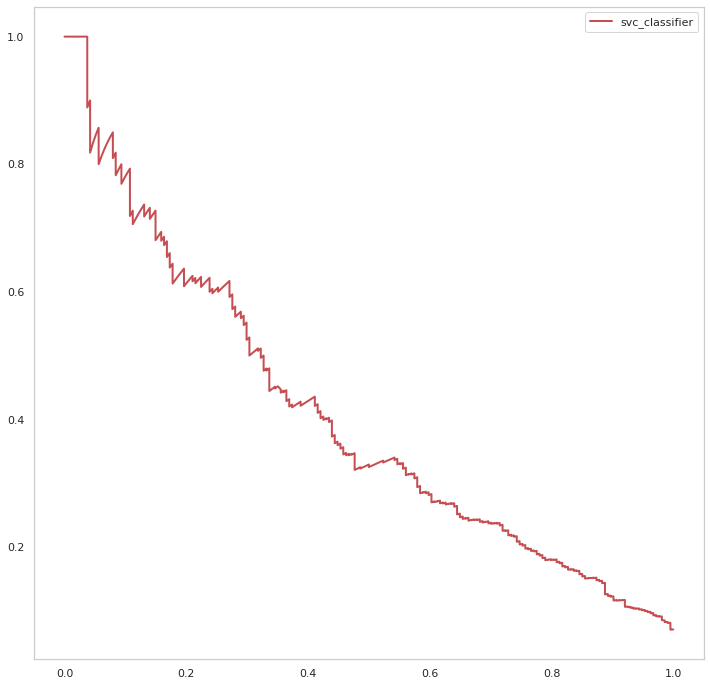

In [19]:
figure(num=None, figsize=(12, 12))
# prec, recl, thresholds = precision_recall_curve(labels_test, pred_probs[:,1])
# plt.plot(recl, prec, 'k-', linewidth=1, label='lr_classifier')
prec, recl, thresholds = precision_recall_curve(labels_test, y_pred_probs[:,1])
plt.plot(recl, prec, 'r-', linewidth=2, label='svc_classifier')
# prec, recl, thresholds = precision_recall_curve(labels_test, pred_probs_3[:,1])
# plt.plot(recl, prec, 'b-', linewidth=1, label='mlp_classifier')
# prec, recl, thresholds = precision_recall_curve(labels_test, pred_probs_avg)
# plt.plot(recl, prec, 'g-', linewidth=1, label='general')
# prec, recl, thresholds = precision_recall_curve(labels_test, pred_probs_4[:,1])
# plt.plot(recl, prec, 'g-', linewidth=1, label='svc_classifier_3')
plt.legend()

In [21]:
for p, r, thres in zip(prec, recl, thresholds):
    if 0.6<p and 0.25<r:
        f1 = 2*p*r / (p+r)
        print(f'{thres:.7}\t{r:.4}\t{p:.4}\t{f1:.4}')

0.4313653	0.271	0.6042	0.3742
0.4328957	0.271	0.6105	0.3754
0.4372501	0.271	0.617	0.3766
0.437945	0.2664	0.6129	0.3713
0.4381403	0.2617	0.6087	0.366
0.4404731	0.257	0.6044	0.3607
0.4418132	0.2523	0.6067	0.3564


In [22]:
y_test = labels_test
y_prob_text = y_pred_probs[:,1]
y_pred = [1 if yy > 0.32 else 0 for yy in y_prob_text]
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
accuracy, recall, precision, f1

(83.31750553972776, 68.22429906542055, 24.132231404958677, 35.653235653235654)

In [30]:
import pickle

with open('FE_telesale_44h_52h/models/telesale_vectorizer.pkl', 'rb') as f:
    tfidf_ = pickle.load(f)

with open('FE_telesale_44h_52h/models/telesale_classifier.pkl', 'rb') as f:
    svc_classifier_ = pickle.load(f)

In [31]:
tfidf_features = tfidf_.transform(trans).toarray()
y_tfidf = svc_classifier_._predict_proba_lr(tfidf_features)[:,1]

ValueError: X has 14764 features per sample; expecting 14772

### Mel-spectrogram inference

In [3]:
df = pd.read_csv('repository/vnlp.engine.ser/resources/train_test_dataset_genesys.csv', header=None, sep='\t')
paths = df[0].apply(lambda x: 'repository/vnlp.engine.ser/resources/FE_genesys_mels/' + x).to_list()
labels = df[1].to_list()
groups = df[2].to_list()
X_test = []; y_test = []

random.seed(1)

for i in tqdm(range(len(paths))):
    if groups[i]=='test':
        X_test.append(torch.from_numpy(np.load(paths[0])))
        y_test.append(labels[i])

100%|██████████████████████████████████| 95717/95717 [00:04<00:00, 23053.98it/s]


In [10]:
melspec = MelspecClassifier()
melspec.load_state_dict(torch.load('checkpoints/checkpoint_best_loss.pt', map_location=torch.device('cuda')))
melspec.eval()
melspec.cuda()

y_prob = []
for i in tqdm(range(0, len(y_test), 24)):
    X_test_ = torch.stack(X_test[i : i + 24]).cuda()
    y_prob.extend(melspec(X_test_).data[:, 1].cpu().numpy())

100%|█████████████████████████████████████████| 793/793 [00:42<00:00, 18.81it/s]


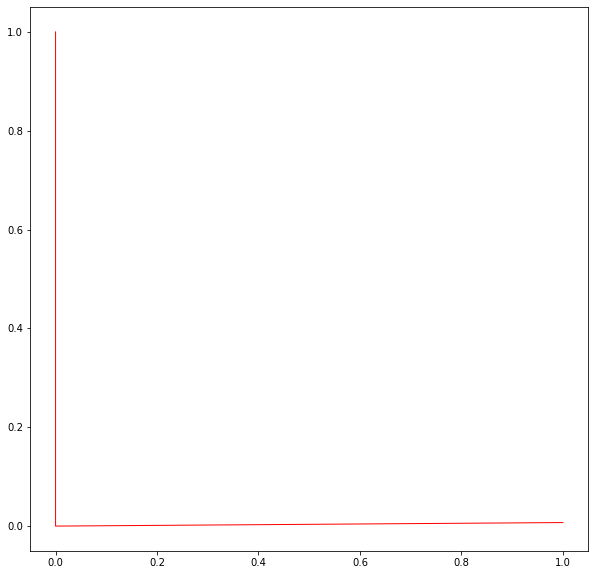

In [7]:
figure(num=None, figsize=(10, 10))
prec, recl, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recl, prec, 'r-', linewidth=1, label='mels_classifier')

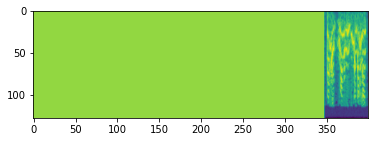

In [38]:
img = np.load('repository/vnlp.engine.ser/resources/FE_genesys_mels/84d8d974b731428892045ce97ed7bba5__4BV3CEU4SH71P0NN5TFDBD1P9C05SMC9_2021-01-11_05-53-00-012201FF-12592A3E-00000001-client_25.npy').T
plt.imshow(img)

### General sentiment (AND/OR operator)

In [99]:
y_test = y78
y_pred = [1 if 0.1*y1+0.9*y2>0.38 else 0 for y1, y2 in zip(y_prob_voice, y_prob_text)]
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
accuracy, recall, precision, f1

(99.30062575590262, 11.029411764705882, 55.55555555555556, 18.404907975460123)

In [47]:
from sklearn.linear_model import LogisticRegression

X_general = np.array([y_prob_voice, y_prob_text]).T

lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=100, class_weight=class_weight)
lr_classifier.fit(X_general, y_test)

LogisticRegression(class_weight={0: 0.9921251629726205, 1: 0.0078748370273794},
                   multi_class='multinomial')

In [48]:
y_prob = lr_classifier.predict_proba(X_general)

In [171]:
import shutil

for i in range(len(y)):
    if y[i]==1 and y_pred[i]==1:
        path = paths[i].replace('training_dataset/FE_telesale_8k_v01_plus', 'FE_telesale_52h/audio').replace('training_dataset/FE_telesale_8k_v02_plus', 'FE_telesale_44h/audio').replace('mfcc', 'wav')
        shutil.copyfile(path, f'true_negatives/{int((y_voice2[i]-0.9999) * 1000000):02}_{i}.wav')

### Export data for general sentiment

In [95]:
with open('sentiments.csv', 'w') as f:
    f.write('voice\ttext\tlabel\n')
    for v,t,l in zip(y_voice, y_text, y):
        f.write(f'{v}\t{t}\t{l}\n')

### TEST CPC_FE

In [ ]:
folders = sorted(['CPC_test/' + folder for folder in os.listdir('CPC_test')])
audios = []
for folder in folders:
    for audio in sorted(os.listdir(folder), key=lambda x: int(x[:-4].split('_')[-1])):
        audios.append(folder + '/' + audio)

wav2senti = VoiceClassifier()
wav2senti.load_state_dict(torch.load('checkpoints/checkpoint_CPC_FE_avg.pt', map_location=torch.device('cuda')))
wav2senti.eval()
wav2senti.cuda()

negative_prob = []
negatives = []
for audio in tqdm(audios):
    features = get_features_from_wav(audio, 600).unsqueeze(0).cuda()
    logits = wav2senti(features).squeeze(0)
    negative_prob.append(logits[1].item())
    if logits[1]>0.99:
        negatives.append(audio[9:])

In [83]:
neg = 0
for prob in negative_prob:
    if prob>0.99:
        neg += 1
neg

123

In [81]:
with open('CPC_test/negatives.txt', 'w') as f:
    f.write('\n\n'.join(negatives))

In [30]:
audios = sorted(['YouTube/' + audio for audio in os.listdir('YouTube')])
wav2senti = VoiceClassifier()
wav2senti.load_state_dict(torch.load('checkpoints/checkpoint_CPC_FE_avg.pt', map_location=torch.device('cuda')))
wav2senti.eval()
wav2senti.cuda()

negative_prob = []
for audio in tqdm(audios):
    features = get_features_from_wav(audio, 600).unsqueeze(0).cuda()
    logits = wav2senti(features).squeeze(0)
    negative_prob.append(logits[1].item())

100%|█████████████████████████████████████████| 297/297 [00:39<00:00,  7.53it/s]


In [33]:
for prob, audio in zip(negative_prob, audios):
    if prob>0.1:
        print(prob, audio)
#negative_prob[:10]

0.3285583555698395 YouTube/152.wav
0.16626660525798798 YouTube/71.wav


### TEST PROSODY

In [143]:
df = pd.read_csv('training_dataset/train_dataset_52h.csv', delimiter="\t", header=None)

paths = [p.replace('FE_telesale_52h/audio', 'training_dataset/FE_telesale_v01_prosody').replace('.wav', '.npy') for p in df[0].to_list()]
X = [torch.from_numpy(np.load(p)) for p in paths]
X = torch.nan_to_num(torch.stack(X))
X = X.reshape(len(X), -1)
#X = torch.stack([X[:,0], X[:,30]]).T

y = df[3].to_list()

p = df[0].apply(lambda x: x.split('__')[0].split('/')[-1]).to_list()

print(X.shape, len(y))

torch.Size([49256, 103]) 49256


In [144]:
zip_Xyp = zip(X, y, p)
zip_Xyp = sorted(zip_Xyp, key=lambda x: x[2])
X_, y_, p_ = zip(*zip_Xyp)
X_ = torch.stack(list(X_))
y_ = np.array(list(y_))

In [145]:
start = 0
for i in range(len(X_)+1):
    if i==len(X_) or (i>0 and p_[i]!=p_[i-1]): #end
        for j in range(103):
            X_[start:i, j] /= X_[start:i, j].mean()
            # X_[start:i, 1] /= X_[start:i, 1].mean()
        start = i
#avg_energy_std = X_[:,39].mean()
#X_[:,39] /= avg_energy_std
#X_ = torch.stack([X_[:,0], X_[:,39]]).T
#X_.shape

In [150]:
X_ = torch.nan_to_num(X_, 1)

#### ANOVA

In [152]:
from scipy import stats

F_value, p_value = stats.f_oneway(X_[np.where(y_==0)], X_[np.where(y_==1)])
F_value.argsort()[-12:][::-1]

array([ 0, 39,  2, 43, 38, 83, 49, 64, 51, 31, 45, 11])

In [153]:
X_ = torch.stack([X_[:,0], X_[:,39], X_[:,38], X_[:,83]]).T
X_.shape

torch.Size([49256, 4])

In [125]:
X_[np.where(y_==0),1].mean(), X_[np.where(y_==1),1].mean(), X_[:,1].mean()

(tensor(0.9972, dtype=torch.float64),
 tensor(1.5645, dtype=torch.float64),
 tensor(1., dtype=torch.float64))

In [47]:
df = pd.read_csv('training_dataset/test_dataset_52h.csv', delimiter="\t", header=None)

paths = [p.replace('FE_telesale_52h/audio', 'training_dataset/FE_telesale_v01_prosody').replace('.wav', '.npy') for p in df[0].to_list()]
X_test = [torch.from_numpy(np.load(p)) for p in paths]
X_test = torch.nan_to_num(torch.stack(X_test))
X_test = X_test.reshape(len(X_test), -1)

y_test = df[3].to_list()

X_test = pca.transform(X_test)

print(X_test.shape, len(y_test))

(12314, 10) 12314


In [154]:
w_0 = len(y) / (len(y) - sum(y))
w_1 = len(y) / sum(y)
w_0, w_1

(1.004937364834537, 203.53719008264463)

In [157]:
from sklearn.svm import SVC

model = SVC(C=0.0001, gamma=0.0001, kernel='rbf', class_weight={0: w_0, 1: w_1})
model.fit(X_, y_)

y_pred = model.predict(X_)

print(accuracy_score(y_, y_pred)*100)
print(recall_score(y_, y_pred)*100)
print(precision_score(y_, y_pred)*100)

99.50868929673543
0.0
0.0


/home/kiethoang/.local/lib/python3.9/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


In [88]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred)*100)
print(recall_score(y_test, y_pred)*100)
print(precision_score(y_test, y_pred)*100)

23.01445509176547
91.93548387096774
0.5979857322702475


## Evaluate model

## Visualization - Explore datasets

In [33]:
X_viz = torch.nan_to_num(torch.stack(X))
X_viz = X_viz.reshape(len(X_viz), -1)
X_viz.shape

torch.Size([49256, 103])

In [34]:
y_viz = y
pca = PCA(n_components=10)
components = pca.fit_transform(X_viz)
sorted_zip = sorted(zip(components, y_viz), key = lambda x: x[1])
unzipped = list(zip(*sorted_zip))
components = np.stack(list(unzipped[0]), axis=0)
y_viz = np.stack(list(unzipped[1]), axis=0)
components.shape, y_viz.shape

((49256, 10), (49256,))

In [40]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

1.0
1.0
1.0


In [44]:
print(sum(y_pred), len(y_pred))
print(sum(y_viz), len(y_viz))

242 49256
242 49256


In [30]:
y_viz = y
tsne = TSNE(n_components=2, random_state=0)
components = tsne.fit_transform(X_viz)
sorted_zip = sorted(zip(components, y_viz), key = lambda x: x[1])
unzipped = list(zip(*sorted_zip))
components = np.stack(list(unzipped[0]), axis=0)
y_viz = np.stack(list(unzipped[1]), axis=0)
components.shape, y_viz.shape

((49256, 2), (49256,))

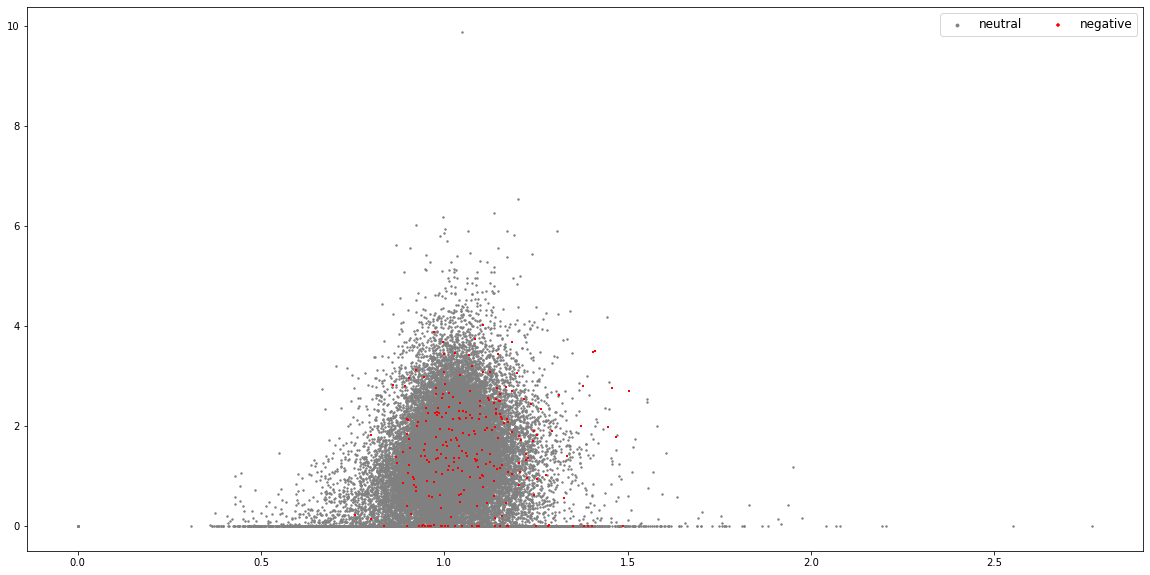

In [115]:
colors = {0:'gray', 1:'red'}
labels = {0:'neutral', 1:'negative'}
markers = {0:'o', 1:'+'}
sizes = {0:2, 1:5}
figure(num=None, figsize=(20, 10))
for i in range(2):
    grouped_points = X_[np.where(y_==i)]
    plt.scatter(grouped_points[:,0], grouped_points[:,1], marker=markers[i], c=colors[i], s=sizes[i], label=labels[i])
plt.legend(fontsize=12, markerscale=2, ncol=2)
#plt.savefig('visualization/v5/distribution_test_full.png', dpi=300)

## Export data for LM

In [7]:
import pandas as pd

df = pd.read_csv(os.path.join('FE_telesale_52h', 'Label_Data_Sentiment_52h.lst'), delimiter="\t", header=None).replace([3, 5], 0)
df.drop([0], axis=1, inplace=True)
df.columns = ['filename', 'negative', 'ref']
df['filename'] = df['filename'].apply(lambda x: x.split('/')[-1])
#df['id'] = df['id'].apply(lambda x: x.split('__')[1])
df.head()

filename  negative  \
0  d0b485800c054eff8809438e4455a196__TQ5L7GHPE54R...         0   
1  d0b485800c054eff8809438e4455a196__TQ5L7GHPE54R...         0   
2  d0b485800c054eff8809438e4455a196__TQ5L7GHPE54R...         0   
3  d0b485800c054eff8809438e4455a196__TQ5L7GHPE54R...         0   
4  d0b485800c054eff8809438e4455a196__TQ5L7GHPE54R...         0   

                                                 ref  
0                                    dạ không phải ạ  
1    giờ chị thành không dùng số này nữa rồi sao chị  
2                      dạ không ạ em mới mua sim này  
3  thế cái số em đang gọi lên tổng đài này có mua...  
4               hình như em nhớ không lầm là em có ạ

In [24]:
s ="[{'start': 200, 'end': 300}, {'start': 400, 'end': 520}, {'start': 560, 'end': 720}, {'start': 800, 'end': 820}]"
s = s[1:-1].replace('}', '} ').replace("'", '"')
ts = s.split(' , ')

import json
d0 = json.loads(ts[0])
print(d0, type(d0))

{'start': 200, 'end': 300} <class 'dict'>


In [37]:
infos = [df['id'].iloc[i].split('_')[0] + '_' + f"{df['time'].iloc[i]:08}" + '_' + ('0' if 'agent' in df['id'].iloc[i] else '1') for i in range(len(df))]
df['info'] = infos
df['id'] = df['id'].apply(lambda x: x.split('_')[0])
df.sort_values(by=['info'], inplace=True)
df.head()

id  \
4374  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM   
4375  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM   
4376  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM   
4377  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM   
4378  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM   

                                                   text   time  \
4374  chị chị có cái đó không chị cái ứng dụng em mớ...   1380   
4375         đúng rồi là cái đó là cái xê hát pờ lây đó   8310   
4376                        rồi rồi chị ấn tay vô đó nè  10590   
4377                        chị ấn tay vô đó chị ấn chị  12450   
4378                                    chị mở nó ra đi  15760   

                                             info  
4374  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM_00001380_1  
4375  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM_00008310_1  
4376  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM_00010590_1  
4377  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM_00012450_1  
4378  TQ5L7GHPE54R5BS3I8IR40E2S008KBUM_00015760_1

In [35]:
corpus = []
paragraph = [df['text'].iloc[0]]
for i in range(1, len(df)):
    if df['id'].iloc[i] == df['id'].iloc[i-1]:
        paragraph.append(df['text'].iloc[i])
    elif len(paragraph) > 0:
        for i in range(0, len(paragraph), 5):
            corpus.append(' . '.join(paragraph[i:min(i+5, len(paragraph))]))
        paragraph = []
corpus.append(' . '.join(paragraph))

In [41]:
with open('telesale_52h_train_joint.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(corpus))

In [6]:
import shutil
from tqdm import tqdm

sources = df[1].to_list()

for s in tqdm(sources):
    t = 'telesale-nega/' + s.split('/')[-1]
    shutil.copyfile(s, t)

100%|██████████| 304/304 [00:00<00:00, 2166.58it/s]


In [7]:
targets = [s.split('/')[-1] for s in sources]
df[1] = targets
df.head()

1  \
256   3d90d7c5bfd0402d94c2c87514987bbc__TQ5L7GHPE54R...   
563   950f695d2ddf4a84b64e76bcf8ed9108__TQ5L7GHPE54R...   
1027  862172720c0a404cb1d30d5b68977ba4__TQ5L7GHPE54R...   
1028  862172720c0a404cb1d30d5b68977ba4__TQ5L7GHPE54R...   
1032  862172720c0a404cb1d30d5b68977ba4__TQ5L7GHPE54R...   

                                                      3  
256               thì em đừng liên lạc với số này nữa ừ  
563     không hiểu nó ra cái gì luôn á chị bấm thoát ra  
1027  hay là gì anh nói cái gì à năm chục triệu có h...  
1028  anh có bị nhấn lời lộn tiền gì không trời ơi a...  
1032  bây giờ anh hỏi anh anh nói chuyện còn không n...

In [8]:
df.to_csv('telesale-nega/ref.csv', header=None, sep=',')
#df = pd.read_csv('telesale-ped/ref.csv', delimiter=",", header=None, index_col=0)

In [10]:
import numpy as np
arr = np.load("/home/kiethoang/Projects/VoiceSentiment/repository/vnlp.engine.ser/resources/FE_genesys_mels/0a4b0b542cfd45d9aad31a58f53d7b59__4BV3CEU4SH71P0NN5TFDBD1P9C05O0FJ_2021-01-11_02-29-38-012201FF-1258A134-00000001-agent_0.npy")

In [12]:
arr.shape

(400, 128)

In [17]:
import pandas as pd
df = pd.read_csv('/home/kiethoang/Projects/VoiceSentiment/repository/vnlp.engine.ser/resources/train_test_dataset_genesys.csv', header=None, sep='\t')
df.head()

0  1      2
0  73e35f6cd0934e109d6f235fcbf0f73a__4BV3CEU4SH71...  0  train
1  73e35f6cd0934e109d6f235fcbf0f73a__4BV3CEU4SH71...  0  train
2  73e35f6cd0934e109d6f235fcbf0f73a__4BV3CEU4SH71...  0  train
3  73e35f6cd0934e109d6f235fcbf0f73a__4BV3CEU4SH71...  0  train
4  73e35f6cd0934e109d6f235fcbf0f73a__4BV3CEU4SH71...  0  train

In [18]:
labels = df[1].to_list()
paths = df[0].apply(lambda x: '/home/kiethoang/Projects/VoiceSentiment/repository/vnlp.engine.ser/resources/FE_genesys_mels/' + x).to_list()
paths[0]

'/home/kiethoang/Projects/VoiceSentiment/repository/vnlp.engine.ser/resources/FE_genesys_mels/73e35f6cd0934e109d6f235fcbf0f73a__4BV3CEU4SH71P0NN5TFDBD1P9C05TK58_2021-01-11_06-36-44-012301FF-12594B46-00000001-agent_0.npy'

In [19]:
arr = np.load(paths[0])
arr.shape

(400, 128)